In [49]:
import matplotlib.pyplot as plt
import pandas
import functools 

import pmana.utils

In [2]:
TIME_DIR = "20250902"
TIME_RANGE = "20250902_20250905"

#### Parse Padova test-stand data

In [3]:
PATH_INPUT  = f"/Users/triozzi/Downloads/Test_{TIME_RANGE}"
PATH_TARGET = f"../data/{TIME_DIR}/DataPadova_{TIME_RANGE}"

pmana.utils.io.FormatPadovaData(
    PATH_INPUT,  ###< raw Padova test-stand campaign
    PATH_TARGET  ###< target path for the restructured data
)

Skipping unrecognized file: TemperatureLog_20250901_.txt
Skipping unrecognized file: Test condition.txt.txt


#### Look at one single measurement

There were 3 used channels in this campaign.


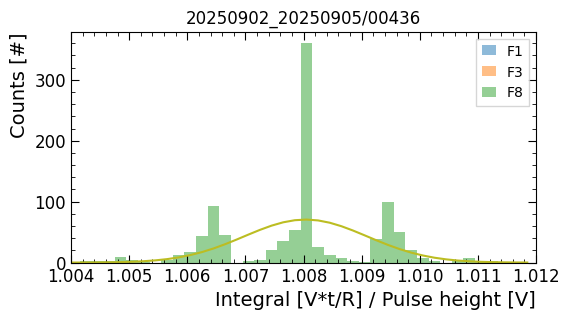

In [57]:
fig, ax = plt.subplots(figsize=(6,3))

MEASUREMENT = '00436'
# extract a measurement 
Data = pmana.utils.io.ExtractSingleMeasurement(
    f"../data/{TIME_DIR}/DataPadova_{TIME_RANGE}/{MEASUREMENT}"
)
print(f"There were {len(Data)} used channels in this campaign.")

ax.set_xlim(1.004, 1.012)

CHs = [1, 3, 8]
for i, chname in enumerate(CHs):
    # plot channel data
    pmana.utils.plotting.PlotSingleChannel(
        Data[i],
        ax,
        channel = chname,
        rebin = True
    )

ax = pmana.utils.plotting.UpdateMatplotlibStyle(
    ax,
    "Integral [V*t/R] / Pulse height [V]",
    "Counts [#]"
)

ax.set_title(f"{TIME_RANGE}/{MEASUREMENT}")
ax.set_xlim(1.004, 1.012) 
# ax.set_xlim(0.54, 0.59)
# ax.set_xlim(1e-6, 2e-6)
plt.show()

#### Analyze a campaign

In [5]:
PATH_CAMPAIGN = f"../data/{TIME_DIR}/DataPadova_{TIME_RANGE}"
PATH_TEMPERATURES = f"../data/{TIME_DIR}/PM_Temperature_{TIME_RANGE}.txt"
PATH_TIMES = f"../data/{TIME_DIR}/PadovaData_{TIME_RANGE}_TimeMapping.txt"

In [6]:
# get temperature mapping
Temperatures = pmana.utils.io.ExtractTemperatureMonitoring(
    PATH_TEMPERATURES
)

# get time mapping
TimeMapping = pmana.utils.io.ExtractFileTimes(
    PATH_TIMES
)

In [50]:
# analyze campaign
Output = pmana.utils.anatestdata.Iterate(
    PATH_CAMPAIGN,                                                              ###< path to restructured data
    # pmana.utils.anatestdata.AnalyzeMeasurement,                               ###< analyzing module 
    functools.partial(pmana.utils.anatestdata.AnalyzeMeasurement, rebin=True),  ###< analyzing module, if you want to change some options 
    TimeMapping                                                                 ###< file-to-time mapping
)

# convert top DataFrame
Output = pandas.DataFrame(Output)

# re-format the dataframe
Output.columns = ["Peak_CH1", "Err_Peak_CH1", "Width_CH1", "Err_Width_CH1",
                  "Peak_CH2", "Err_Peak_CH2", "Width_CH2", "Err_Width_CH2", 
                  "Peak_CH3", "Err_Peak_CH3", "Width_CH3", "Err_Width_CH3", 
                  "Date", "Number"]

# sort by date
Output.sort_values(
    by = 'Date', 
    inplace = True,
    ignore_index = True
)

/Users/triozzi/Analysis/pmana/pmana/utils/anatestdata.py:114: OptimizeWarning: Covariance of the parameters could not be estimated
  pars, covs = scipy.optimize.curve_fit(


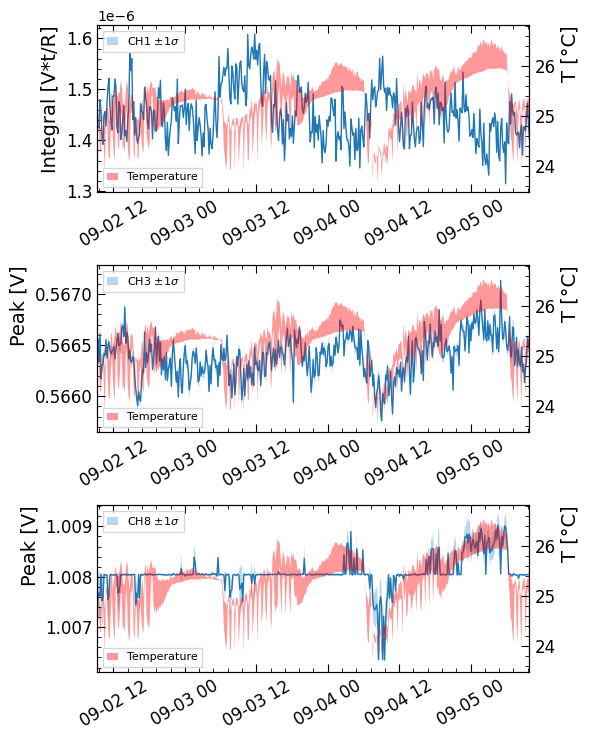

In [52]:
fig, ax = plt.subplots(figsize=(6, 2.5*3), nrows=3, layout='tight')

# CH1
ax[0].plot(Output.Date, Output.Peak_CH1, lw=1)
ax[0].fill_between(Output.Date, Output.Peak_CH1-Output.Err_Peak_CH1,  Output.Peak_CH1+Output.Err_Peak_CH1, alpha=0.3, label='CH1 $\\pm1\\sigma$')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[0], None, 'Integral [V*t/R]')

# CH3
ax[1].plot(Output.Date, Output.Peak_CH2, lw=1)
ax[1].fill_between(Output.Date, Output.Peak_CH2-Output.Err_Peak_CH2,  Output.Peak_CH2+Output.Err_Peak_CH2, alpha=0.3, label='CH3 $\\pm1\\sigma$')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[1], None, 'Peak [V]')

# CH4
ax[2].plot(Output.Date, Output.Peak_CH3, lw=1)
ax[2].fill_between(Output.Date, Output.Peak_CH3-Output.Err_Peak_CH3,  Output.Peak_CH3+Output.Err_Peak_CH3, alpha=0.3, label='CH8 $\\pm1\\sigma$')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[2], None, 'Peak [V]')

for a in ax:
    # gfx
    a.legend(frameon=True, fancybox=False, handlelength=1, fontsize=8, loc='upper left')
    a.tick_params(axis='x', labelrotation=30)
    a.set_xlim(Output['Date'].iloc[0], Output['Date'].iloc[-1])

    # plot temperatures
    a2 = a.twinx()
    a2.fill_between(Temperatures.Date, y1=Temperatures.T1, y2=Temperatures.T2, fc='red', alpha=0.4, label='Temperature', zorder=-3)
    pmana.utils.plotting.UpdateMatplotlibStyle(a2, None, 'T [°C]')
    a2.legend(frameon=True, fancybox=False, handlelength=1, fontsize=8, loc='lower left')

plt.show()

#### Merge all campaigns

In [3]:
PATH_DATA = "../data"

In [4]:
# analyze all campaigns together
Output, Temperatures = pmana.utils.anatestdata.MergeCampaigns(
    PATH_DATA,
    pmana.utils.io.ExtractFileTimes,
    pmana.utils.io.ExtractTemperatureMonitoring,
    pmana.utils.anatestdata.Iterate,
    pmana.utils.anatestdata.AnalyzeMeasurement
)

# format the output nicely
Output = pandas.DataFrame(Output)
Output.columns = ["Peak_CH1", "Err_Peak_CH1", "Width_CH1", "Err_Width_CH1",
                  "Peak_CH2", "Err_Peak_CH2", "Width_CH2", "Err_Width_CH2", 
                  "Date", "Number"]
Output.sort_values(
    by = 'Date', 
    inplace = True,
    ignore_index = True
)

# format the temperatures nicely
Temperatures.sort_values(
    by = 'Date', 
    inplace = True,
    ignore_index = True
)

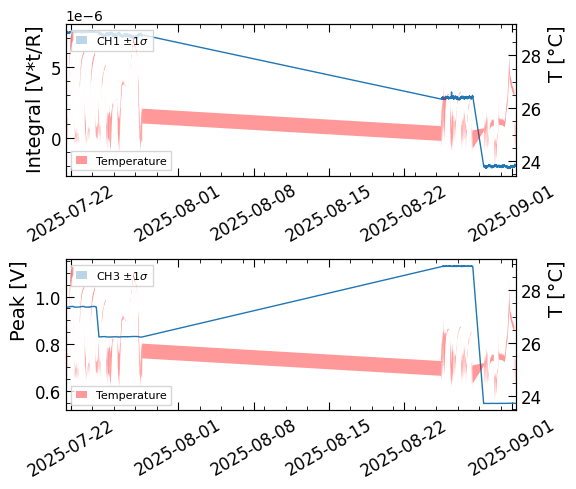

In [9]:
fig, ax = plt.subplots(figsize=(6, 2.5*2), nrows=2, layout='tight')

# CH1
ax[0].plot(Output.Date, Output.Peak_CH1, lw=1)
ax[0].fill_between(Output.Date, Output.Peak_CH1-Output.Err_Peak_CH1,  Output.Peak_CH1+Output.Err_Peak_CH1, alpha=0.3, label='CH1 $\\pm1\\sigma$')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[0], None, 'Integral [V*t/R]')

# CH3
ax[1].plot(Output.Date, Output.Peak_CH2, lw=1)
ax[1].fill_between(Output.Date, Output.Peak_CH2-Output.Err_Peak_CH2,  Output.Peak_CH2+Output.Err_Peak_CH2, alpha=0.3, label='CH3 $\\pm1\\sigma$')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[1], None, 'Peak [V]')

for a in ax:
    # gfx
    a.legend(frameon=True, fancybox=False, handlelength=1, fontsize=8, loc='upper left')
    a.tick_params(axis='x', labelrotation=30)
    a.set_xlim(Output['Date'].iloc[0], Output['Date'].iloc[-1])

    # plot temperatures
    a2 = a.twinx()
    a2.fill_between(Temperatures.Date, y1=Temperatures.T1, y2=Temperatures.T2, fc='red', alpha=0.4, label='Temperature', zorder=-3)
    pmana.utils.plotting.UpdateMatplotlibStyle(a2, None, 'T [°C]')
    a2.legend(frameon=True, fancybox=False, handlelength=1, fontsize=8, loc='lower left')

plt.show()